# Retail Strategy and Analysis

# Introduction
The Quantium retail analytics team has been approached by the category manager of Chips, who wants to better understand the types of customers who purchase Chips and their purchasing behaviour within the region.

The insights from this analysis will feed into the supermarket’s strategic plan for the chip category in the next half year.

In this analysis I will:
- Examine transaction data to look for inconsistencies, missing data, find outliers, correctly identify category items and numeric data across the different tables.
- Examine customer data to check for similar issues in customer data, look for nulls and merge the transaction data and customer data to prepare for data analysis
- Analyze data and customer segments by defining the metrics and looking at total sales, driver of sales, such as where the highest sales are coming from, etc. We will find interesting insights and trends in the data.
- Deep dive into customer segments by defining recommendations from the aformentioned insights, determine which segments we should target, and if packet sizes and form and overall conclusion based on the analysis.

In [2]:
#Import
import pandas as pd
import numpy as np

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Date
from datetime import datetime

#Warnings
import warnings
warnings.filterwarnings('ignore')

#Statistics
from scipy.stats import ttest_ind

#Apriori
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules

In [3]:
#Import datasets
transaction_data = pd.read_csv('QVI_transaction_data.csv')
customer_data = pd.read_csv('QVI_purchase_behaviour.csv')

# Data Cleaning
Goals: 
- Change date column to datetime
- Parse brand and pack sizes
- Remove special characters in PROD_NAME
- Remove salsa brands from PROD_NAME
- Find for outliers
- Replace brand names for similar brands

In [4]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [5]:
#View dataset info
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [6]:
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [7]:
#Converting serial date to datetime
date_changes = []
for i in transaction_data["DATE"]:
    dt = datetime.fromordinal(datetime(1900,1,1).toordinal() + i-2)
    date_changes.append(dt)

transaction_data["DATE"] = date_changes

In [8]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            264836 non-null  datetime64[ns]
 1   STORE_NBR       264836 non-null  int64         
 2   LYLTY_CARD_NBR  264836 non-null  int64         
 3   TXN_ID          264836 non-null  int64         
 4   PROD_NBR        264836 non-null  int64         
 5   PROD_NAME       264836 non-null  object        
 6   PROD_QTY        264836 non-null  int64         
 7   TOT_SALES       264836 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 16.2+ MB


In [9]:
#Check that we are looking at the right products
transaction_data["PROD_NAME"].unique()

array(['Natural Chip        Compny SeaSalt175g',
       'CCs Nacho Cheese    175g',
       'Smiths Crinkle Cut  Chips Chicken 170g',
       'Smiths Chip Thinly  S/Cream&Onion 175g',
       'Kettle Tortilla ChpsHny&Jlpno Chili 150g',
       'Old El Paso Salsa   Dip Tomato Mild 300g',
       'Smiths Crinkle Chips Salt & Vinegar 330g',
       'Grain Waves         Sweet Chilli 210g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Grain Waves Sour    Cream&Chives 210G',
       'Kettle Sensations   Siracha Lime 150g',
       'Twisties Cheese     270g', 'WW Crinkle Cut      Chicken 175g',
       'Thins Chips Light&  Tangy 175g', 'CCs Original 175g',
       'Burger Rings 220g', 'NCC Sour Cream &    Garden Chives 175g',
       'Doritos Corn Chip Southern Chicken 150g',
       'Cheezels Cheese Box 125g', 'Smiths Crinkle      Original 330g',
       'Infzns Crn Crnchers Tangy Gcamole 110g',
       'Kettle Sea Salt     And Vinegar 175g',
       'Smiths Chip Thinly  Cut Original 175g', 'K

In [10]:
#Removing special characters
transaction_data_words = transaction_data["PROD_NAME"].str.replace("&", '')

In [11]:
pattern = r"[0-9]+[gG]"
transaction_data_words = transaction_data["PROD_NAME"].str.replace(pattern, '')

In [12]:
transaction_data_words.head()

0      Natural Chip        Compny SeaSalt
1                    CCs Nacho Cheese    
2      Smiths Crinkle Cut  Chips Chicken 
3      Smiths Chip Thinly  S/Cream&Onion 
4    Kettle Tortilla ChpsHny&Jlpno Chili 
Name: PROD_NAME, dtype: object

In [13]:
words = Counter()
transaction_data_words.str.split().apply(words.update)
print(words)

Counter({'Chips': 49770, 'Kettle': 41288, '&': 35565, 'Smiths': 28860, 'Salt': 27976, 'Cheese': 27890, 'Pringles': 25102, 'Doritos': 24962, 'Crinkle': 23960, 'Corn': 22063, 'Original': 21560, 'Cut': 20754, 'Chip': 18645, 'Chicken': 18577, 'Salsa': 18094, 'Sea': 14145, 'Thins': 14075, 'Sour': 13882, 'Crisps': 12607, 'Vinegar': 12402, 'Chilli': 12389, 'RRD': 11894, 'Infuzions': 11057, 'Supreme': 10963, 'WW': 10320, 'Cobs': 9693, 'Popd': 9693, 'Tortilla': 9580, 'Tostitos': 9471, 'Twisties': 9454, 'Sensations': 9429, 'Old': 9324, 'El': 9324, 'Paso': 9324, 'Dip': 9324, 'Sweet': 7883, 'Lime': 7852, 'Tomato': 7669, 'Cream': 7618, 'Thinly': 7507, 'Tyrrells': 6442, 'And': 6373, 'BBQ': 6351, 'Tangy': 6332, 'Grain': 6272, 'Waves': 6272, 'Lightly': 6248, 'Salted': 6248, 'Soy': 6121, 'Natural': 6050, 'Mild': 6048, 'Red': 5885, 'Rock': 5885, 'Deli': 5885, 'Thai': 4737, 'Burger': 4733, 'Swt': 4718, 'Chives': 4687, 'Honey': 4661, 'Nacho': 4658, 'Potato': 4647, 'Cheezels': 4603, 'CCs': 4551, 'Woolworth

In [14]:
words_series = pd.Series(words)
words_series.sort_values(ascending=False)

Chips       49770
Kettle      41288
&           35565
Smiths      28860
Salt        27976
            ...  
Sunbites     1432
Pc           1431
NCC          1419
Garden       1419
Fries        1418
Length: 196, dtype: int64

In [15]:
#There are alot of words with Salsa in them. We want only chips in this dataset so we will remove these values
print(words_series[words_series.index == "Salsa"])

Salsa    18094
dtype: int64


In [16]:
pattern = r"([sS]alsa)"
transaction_data_ns = transaction_data.drop(transaction_data[transaction_data["PROD_NAME"].str.contains(pattern)].index)
transaction_data_ns[transaction_data_ns["PROD_NAME"].str.contains(pattern)].shape[0]

0

In [17]:
#Now we will find for outliers and NA values
transaction_data_ns.isnull().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

In [18]:
transaction_data_ns.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
std,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


We can clearly see that there are outliers in PROD_QTY and TOT_SALES

In [19]:
#We can examine the cases where 200 products are bought
transaction_data_ns[transaction_data_ns["PROD_QTY"] == 200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


The cases where **PROD_QTY** is 200, is bought by the same customer since the loyalty card number is the same. Let's see the behavior of this customer; if this customer has other large quantity transactions.

In [20]:
transaction_data_ns[transaction_data_ns["LYLTY_CARD_NBR"] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


It looks like this customer has only made two transactions and is not an ordinary retail customer. This customer might be buying for commercial purposes instead. We will remove these two values.

In [21]:
transaction_data_ns = transaction_data_ns.drop(transaction_data_ns[transaction_data_ns["LYLTY_CARD_NBR"] == 226000].index)
transaction_data_ns[transaction_data_ns["LYLTY_CARD_NBR"] == 226000].shape[0]

0

Now we will check the transaction line over time to see if there are any obvious data issues such as missing values

In [22]:
transaction_per_date = transaction_data_ns["DATE"].value_counts()
print(transaction_per_date)

2018-12-24    865
2018-12-23    853
2018-12-22    840
2018-12-19    839
2018-12-20    808
             ... 
2019-06-24    612
2018-10-18    611
2018-11-25    610
2018-09-22    609
2019-06-13    607
Name: DATE, Length: 364, dtype: int64


It seems like there is a missing date since there are only 364 rows

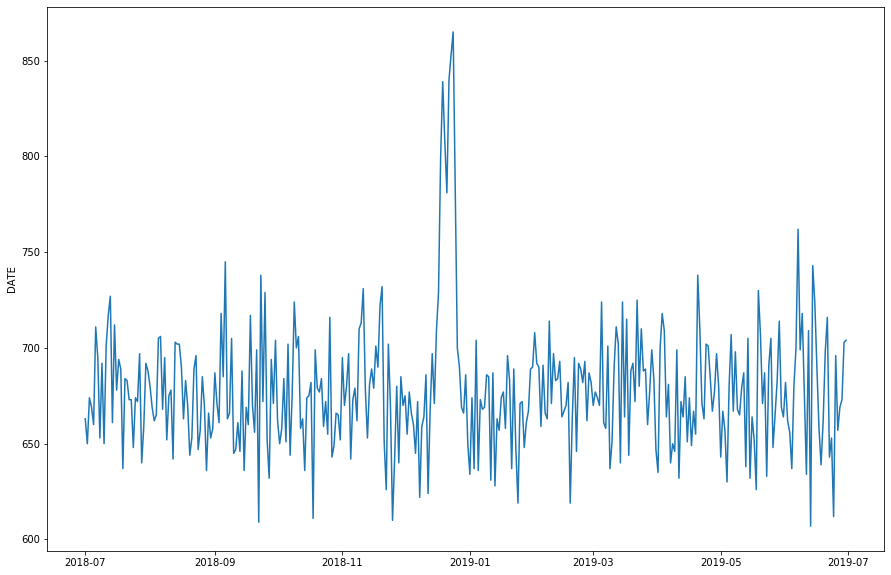

In [23]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.lineplot(transaction_per_date.index, transaction_per_date, ax=ax)

It is obvious that there is an outlier between 2018-11 to 2019-01.

[(737029.0, 737060.0)]

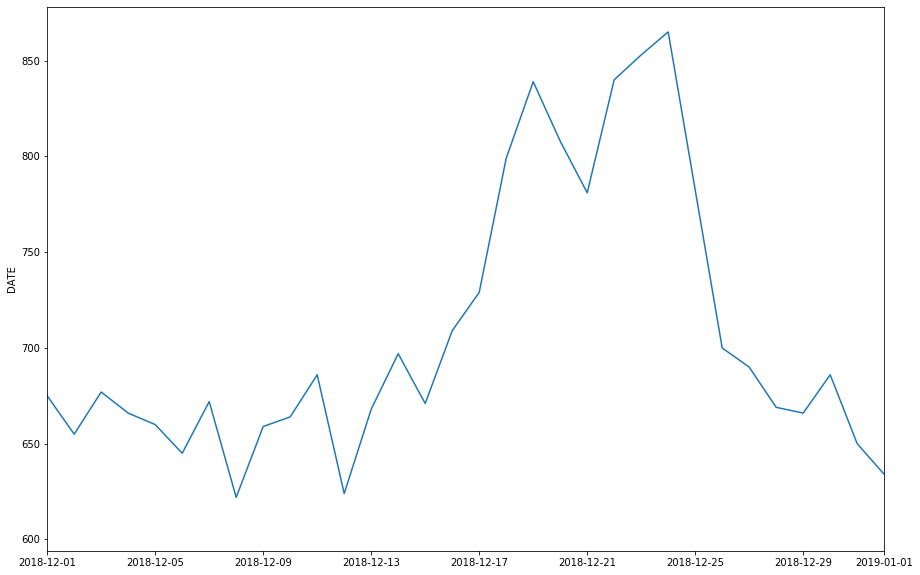

In [24]:
fig1, ax1 = plt.subplots(figsize=(15,10))
ax1 = sns.lineplot(transaction_per_date.index, transaction_per_date, ax=ax1)
ax1.set(xlim=(datetime(2018,12,1), datetime(2019,1,1)))

In [25]:
print(transaction_data_ns[transaction_data_ns["DATE"] == datetime(2018,12,25)].shape[0])

0


We can see that leading up to christmas, there is a surge in transactions. However, during christmas day, there is 0 purchases. This is due to stores closing during christmas day. This does not count as an outlier. Now we will examine the package size and brands of chips.

In [26]:
pattern = r"([0-9]+)"
transaction_data_ns["pack_size"] = transaction_data_ns["PROD_NAME"].str.extract(pattern).astype(int)
transaction_data_ns["pack_size"].unique()

array([175, 170, 150, 330, 210, 270, 220, 125, 110, 134, 380, 180, 165,
       135, 250, 200, 160, 190,  90,  70])

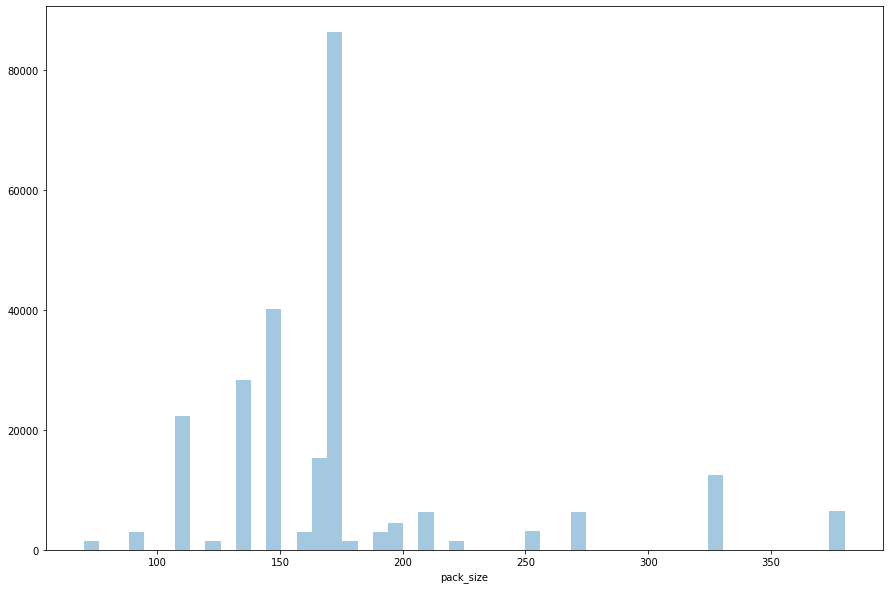

In [27]:
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(transaction_data_ns["pack_size"], kde=False)

In [28]:
transaction_data_ns["pack_size"].describe()

count    246740.000000
mean        175.583521
std          59.432118
min          70.000000
25%         150.000000
50%         170.000000
75%         175.000000
max         380.000000
Name: pack_size, dtype: float64

The pack sizes look reasonable. The minimum value is 70g and the maximum value is 380g. Most of the chips are around the 170g area which seems about right. Let's examine the different brands in the chips dataset.

In [29]:
transaction_data_ns["brands"] = transaction_data_ns["PROD_NAME"].str.split().str[0]
transaction_data_ns["brands"].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'French', 'RRD', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

In [30]:
print(transaction_data_ns[transaction_data_ns["brands"] == "RRD"]["brands"].value_counts())
print(transaction_data_ns[transaction_data_ns["brands"] == "Red"]["brands"].value_counts())

RRD    11894
Name: brands, dtype: int64
Red    4427
Name: brands, dtype: int64


Some brand names look like they are of the same brands. For example Red and RRD are both Red Rock Deli Chips. We will combine these together.

In [31]:
transaction_data_ns["brands"] = transaction_data_ns["brands"].str.lower().str.replace("red", "rrd")
transaction_data_ns[transaction_data_ns["brands"] == "rrd"]["brands"].value_counts()

rrd    16321
Name: brands, dtype: int64

In [32]:
transaction_data_ns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246740 entries, 0 to 264835
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            246740 non-null  datetime64[ns]
 1   STORE_NBR       246740 non-null  int64         
 2   LYLTY_CARD_NBR  246740 non-null  int64         
 3   TXN_ID          246740 non-null  int64         
 4   PROD_NBR        246740 non-null  int64         
 5   PROD_NAME       246740 non-null  object        
 6   PROD_QTY        246740 non-null  int64         
 7   TOT_SALES       246740 non-null  float64       
 8   pack_size       246740 non-null  int32         
 9   brands          246740 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(5), object(2)
memory usage: 19.8+ MB


# Data Preparation
Goals:
- Show distributions for brands and pack size
- Combine transaction_data and customer_data
- Find for nulls

[Text(0, 0.5, ''), Text(0.5, 0, 'Brands')]

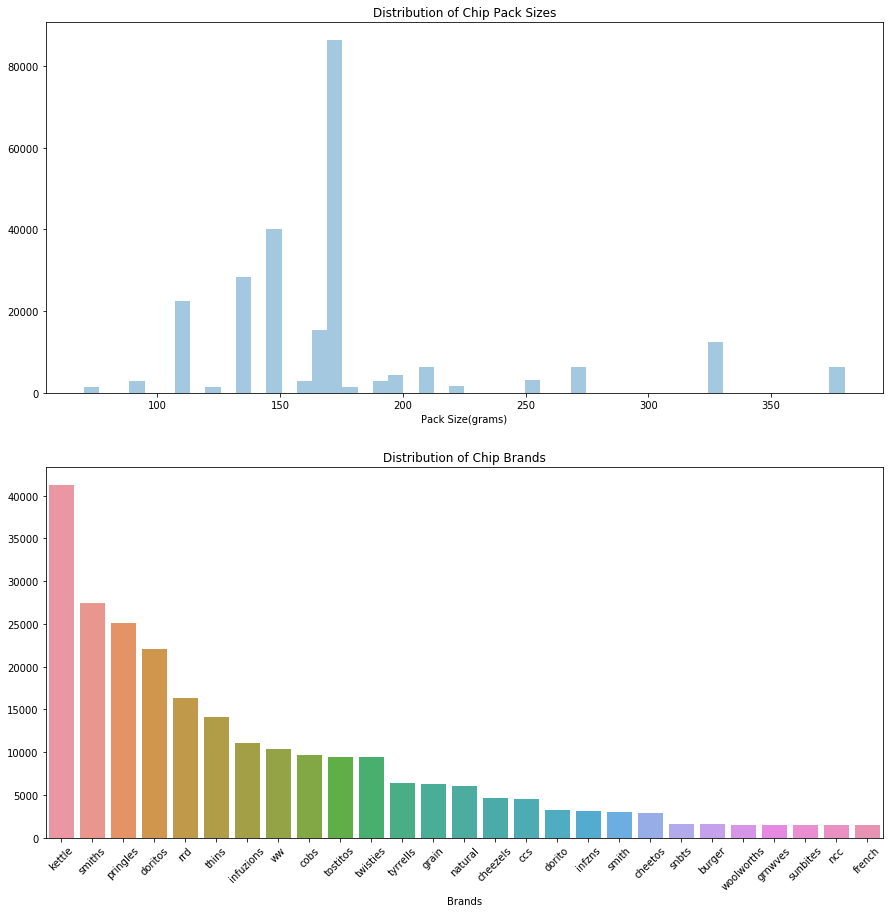

In [33]:
#Visualizing brand and pack size distributions
brand = pd.Series(transaction_data_ns["brands"].value_counts())
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
sns.distplot(transaction_data_ns["pack_size"], kde=False, ax=ax1).set_title("Distribution of Chip Pack Sizes")
sns.barplot(x=brand.index, y=brand, ax=ax2).set_title("Distribution of Chip Brands")
ax1.set(xlabel="Pack Size(grams)")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.set(xlabel="Brands", ylabel="")

In [34]:
customer_transaction = pd.merge(transaction_data_ns, customer_data, on="LYLTY_CARD_NBR", how="left")
customer_transaction.columns

Index(['DATE', 'STORE_NBR', 'LYLTY_CARD_NBR', 'TXN_ID', 'PROD_NBR',
       'PROD_NAME', 'PROD_QTY', 'TOT_SALES', 'pack_size', 'brands',
       'LIFESTAGE', 'PREMIUM_CUSTOMER'],
      dtype='object')

In [35]:
#Check for NULLS
customer_transaction.isnull().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
pack_size           0
brands              0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [36]:
#Save current dataset to a CSV file
customer_transaction.to_csv('customer_transaction.csv', encoding='utf-8')

# Exploratory Data Analysis
Some questions that we will answer in this analysis:
- Who spends the most on chips (total sales), describing customers by lifestage and
how premium their general purchasing behaviour is
- How many customers are in each segment
- How many chips are bought per customer by segment
- What's the average chip price by customer segment
We could also ask our data team for more information. Examples are:
- The customer's total spend over the period and total spend for each transaction
to understand what proportion of their grocery spend is on chips
- Proportion of customers in each customer segment overall to compare against the
mix of customers who purchase chips

Let's start with calculating total sales by LIFESTAGE and PREMIUM_CUSTOMER and
plotting the split by these segments to describe which customer segment contribute
most to chip sales.

In [37]:
customer_transaction.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,pack_size,brands,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,ccs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,kettle,MIDAGE SINGLES/COUPLES,Budget


In [38]:
#Total Sales per LIFESTAGE
customer_transaction_lifestage_premium = customer_transaction.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"]).agg("sum")["TOT_SALES"].sort_values(ascending=False)
customer_transaction_lifestage_premium

LIFESTAGE               PREMIUM_CUSTOMER
OLDER FAMILIES          Budget              156863.75
YOUNG SINGLES/COUPLES   Mainstream          147582.20
RETIREES                Mainstream          145168.95
YOUNG FAMILIES          Budget              129717.95
OLDER SINGLES/COUPLES   Budget              127833.60
                        Mainstream          124648.50
                        Premium             123537.55
RETIREES                Budget              105916.30
OLDER FAMILIES          Mainstream           96413.55
RETIREES                Premium              91296.65
YOUNG FAMILIES          Mainstream           86338.25
MIDAGE SINGLES/COUPLES  Mainstream           84734.25
YOUNG FAMILIES          Premium              78571.70
OLDER FAMILIES          Premium              75242.60
YOUNG SINGLES/COUPLES   Budget               57122.10
MIDAGE SINGLES/COUPLES  Premium              54443.85
YOUNG SINGLES/COUPLES   Premium              39052.30
MIDAGE SINGLES/COUPLES  Budget           

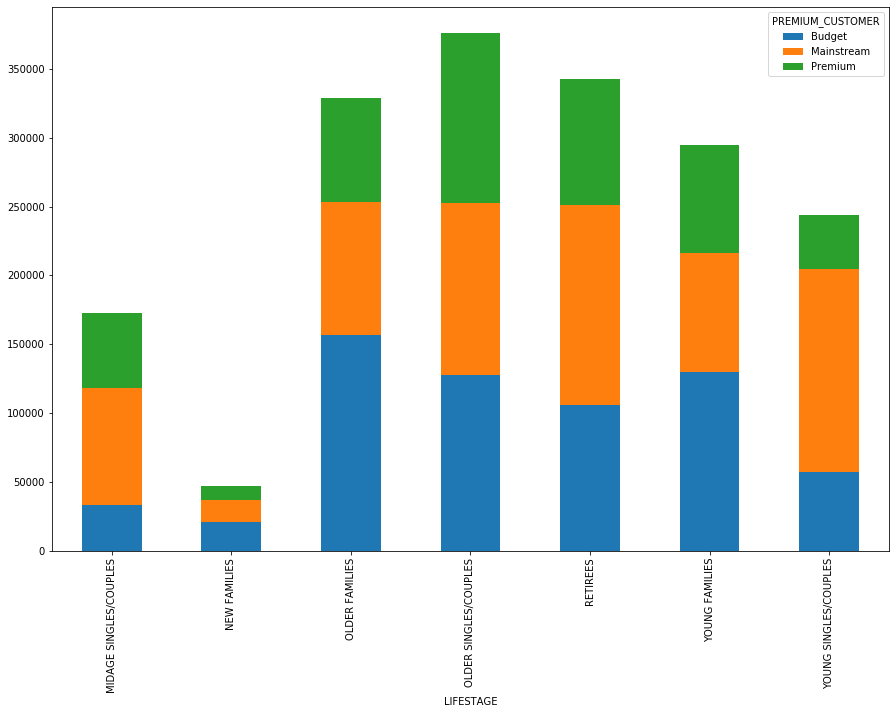

In [39]:
customer_transaction_lifestage_premium.unstack().plot(kind="bar", stacked=True, figsize=(15,10))

It seems like sales are mostly coming from **Budget-older families**, **Mainstream-young single/couples**, **and Mainstream-Retirees**. Let's see if the higher sales come from there being more customers who buy chips

In [48]:
customer_count = customer_transaction.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"]).agg("count")["LYLTY_CARD_NBR"].sort_values(ascending=False)
customer_count

LIFESTAGE               PREMIUM_CUSTOMER
OLDER FAMILIES          Budget              21514
RETIREES                Mainstream          19970
YOUNG SINGLES/COUPLES   Mainstream          19544
YOUNG FAMILIES          Budget              17763
OLDER SINGLES/COUPLES   Budget              17172
                        Mainstream          17061
                        Premium             16560
RETIREES                Budget              14225
OLDER FAMILIES          Mainstream          13241
RETIREES                Premium             12236
YOUNG FAMILIES          Mainstream          11947
MIDAGE SINGLES/COUPLES  Mainstream          11095
YOUNG FAMILIES          Premium             10784
OLDER FAMILIES          Premium             10403
YOUNG SINGLES/COUPLES   Budget               8573
MIDAGE SINGLES/COUPLES  Premium              7612
YOUNG SINGLES/COUPLES   Premium              5852
MIDAGE SINGLES/COUPLES  Budget               4691
NEW FAMILIES            Budget               2824
         

<Figure size 1440x1080 with 0 Axes>

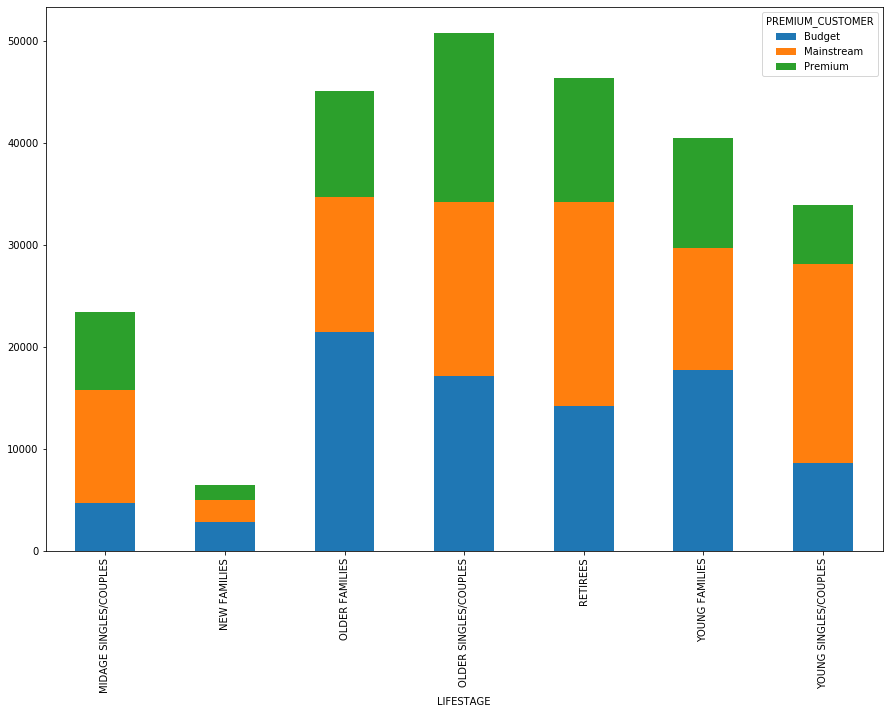

In [49]:
fig = plt.figure(figsize=(20,15))
customer_count.unstack().plot(kind="bar", stacked=True, figsize=(15,10))

There seems to be more Mainstream-Retirees and Mainstream-Young/Single Couples who buy chips. This seems to be the main driver for the high sales in these segments. However, this is not the main driver for Budget-Older Families. Higher sales might also be driven by more units of chips being bought per customer.

In [51]:
customer_count = customer_transaction.groupby(["LIFESTAGE", "LYLTY_CARD_NBR"]).agg(["count"])["TOT_SALES"]
average_count = customer_count.groupby("LIFESTAGE").agg("mean").sort_values(by="count", ascending=False)
average_count

,count
LIFESTAGE,
OLDER FAMILIES,4.689304
YOUNG FAMILIES,4.481408
OLDER SINGLES/COUPLES,3.529988
MIDAGE SINGLES/COUPLES,3.276572
RETIREES,3.190038
NEW FAMILIES,2.607143
YOUNG SINGLES/COUPLES,2.418755


Text(0.5, 1.0, 'Average unit per customer')

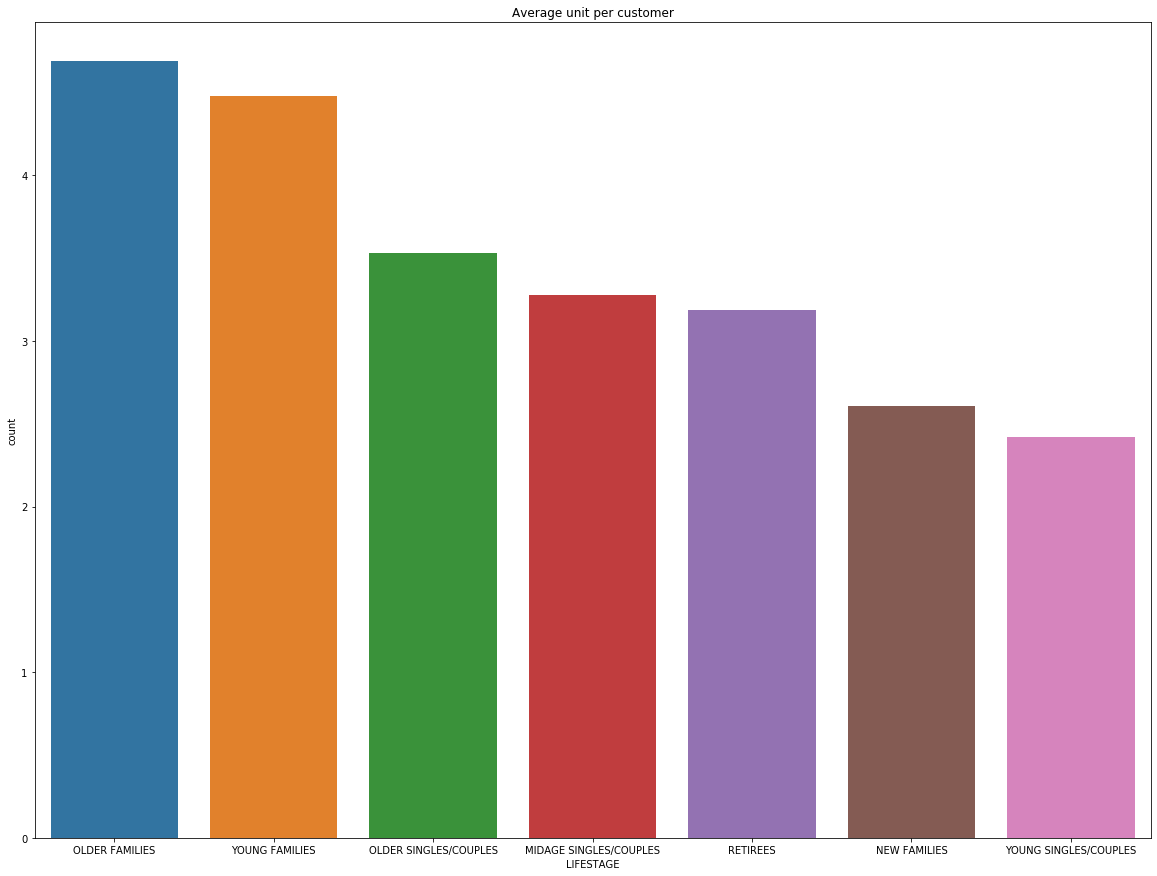

In [52]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(1,1,1)
sns.barplot(x=average_count.index, y=average_count["count"], ax=ax).set_title("Average unit per customer")

Older families and young families in general buy more chips per customer.

In [53]:
average_sales = customer_transaction.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"]).agg(["mean"])["TOT_SALES"].sort_values(by="mean", ascending=False)
average_sales

,,mean
LIFESTAGE,PREMIUM_CUSTOMER,
MIDAGE SINGLES/COUPLES,Mainstream,7.637156
YOUNG SINGLES/COUPLES,Mainstream,7.551279
RETIREES,Premium,7.461315
OLDER SINGLES/COUPLES,Premium,7.459997
RETIREES,Budget,7.445786
OLDER SINGLES/COUPLES,Budget,7.444305
NEW FAMILIES,Mainstream,7.313364
OLDER SINGLES/COUPLES,Mainstream,7.306049
YOUNG FAMILIES,Budget,7.302705


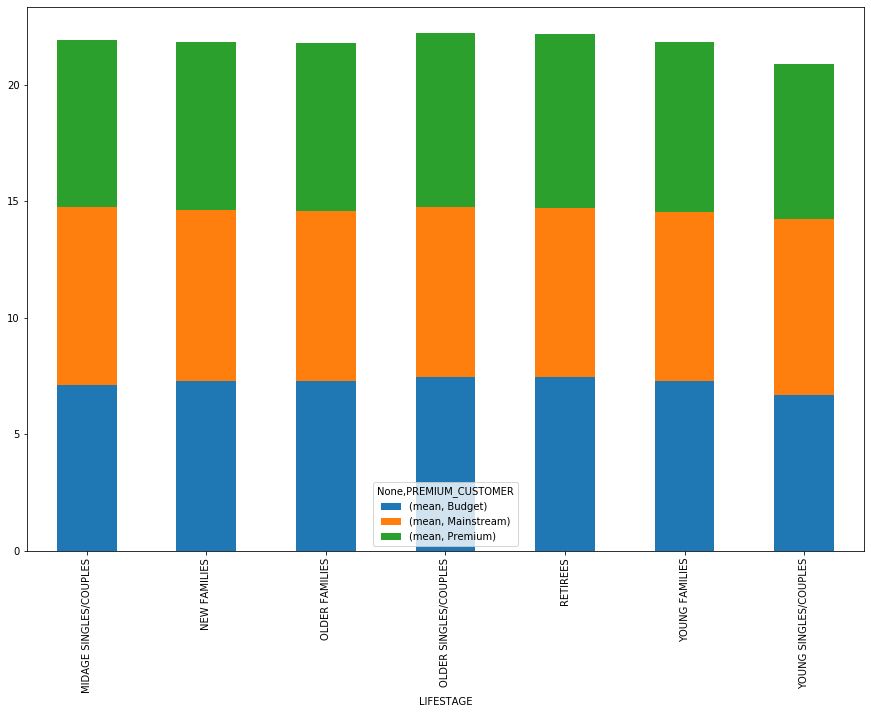

In [54]:
average_sales.unstack().plot(kind="bar", stacked=True, figsize=(15,10))

Mainstream Midage and Young Singles/Couples are more willing to pay more per packet of chips compared to their budget or premium counterparts. This is likely due to premium customers buying healthy snacks and when they buy chips, it is usually for entertainment purposes rather than personal consumption. This is supported by lesser premium midage and young/single couples buying chips compared to their mainstream counterparts. Since the difference in average sales isnt large, we can check if this difference is statistically significant. We will use a T-test between mainstream vs premium and budget midage and young single/couples.

In [55]:
customer_lifestage = customer_transaction[((customer_transaction["LIFESTAGE"] == 'MIDAGE SINGLES/COUPLES') | (customer_transaction["LIFESTAGE"] == 'YOUNG SINGLES/COUPLES'))]
customer_mainstream = customer_lifestage[customer_lifestage["PREMIUM_CUSTOMER"] == 'Mainstream']['TOT_SALES']
customer_budget_premium = customer_lifestage[(customer_lifestage["PREMIUM_CUSTOMER"] == 'Budget') | (customer_lifestage["PREMIUM_CUSTOMER"] == 'Premium') ]['TOT_SALES']

In [56]:
ttest_ind(customer_mainstream, customer_budget_premium)

Ttest_indResult(statistic=33.200521751400586, pvalue=1.9916804791117584e-239)

From the t-test results, we can see that the p-value < 1.9916804791117584e-239. The unit price for mainstream, young and mid-age singles and couples **are** significantly higher than that of budget or premium, young and midage couples.

## Deep dive into specific customer segments for insights

From prior analysis, we have gathered quite a few interesting insights. We can dive deeper into these insights to target customer segments that contribute to most sales so that we can retain them or further increase sales. We will target the Mainstream- Young Singles/Couples and Midage group for this analysis. Let's find out if these group of people tend to buy a paticular brand of chips.

In [57]:
customer_lifestage_mainstream = customer_lifestage[customer_lifestage["PREMIUM_CUSTOMER"] == 'Mainstream']

For this analysis we will use an apriori algorithm. Since we are only focusing on brands, we will only include columns of brands in a new dataset.

In [58]:
customer_brand = customer_lifestage_mainstream[["LYLTY_CARD_NBR","brands"]] 
customer_brand = customer_brand.set_index("LYLTY_CARD_NBR")
customer_brand

,brands
LYLTY_CARD_NBR,
3159,doritos
3294,doritos
4187,kettle
4264,doritos
7036,kettle
...,...
272377,cobs
272389,kettle
272389,pringles


In [59]:
crosstab_customer = pd.crosstab(customer_brand.index, customer_brand["brands"]).rename_axis(None, axis=1)
crosstab_customer = crosstab_customer.clip(0,1)
crosstab_customer

,burger,ccs,cheetos,cheezels,cobs,dorito,doritos,french,grain,grnwves,...,smith,smiths,snbts,sunbites,thins,tostitos,twisties,tyrrells,woolworths,ww
row_0,,,,,,,,,,,,,,,,,,,,,
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1005,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1010,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1018,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1020,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2330041,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2330321,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2370181,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
frequent_itemsets = apriori(crosstab_customer, min_support=0.03, use_colnames=True)
frequent_itemsets.sort_values(by="support", ascending=False)

,support,itemsets
8,0.414802,(kettle)
10,0.269906,(pringles)
4,0.244226,(doritos)
12,0.216585,(smiths)
13,0.147214,(thins)
6,0.121534,(infuzions)
15,0.114757,(twisties)
2,0.114668,(cobs)
14,0.113598,(tostitos)
27,0.109050,"(pringles, kettle)"


From the apriori analysis above, we can see that people who are in the Mainstream-Midage or Young Singles/Couples tend to buy chips from the Kettle brand. Following that, this group of people also like the Pringles brand. Let's see if there are certain brands that are more likely to be bought together.

In [61]:
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.03).sort_values(by="confidence", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
45,"(pringles, doritos)",(kettle),0.065270,0.414802,0.030406,0.465847,1.123060,0.003332,1.095563
31,(tyrrells),(kettle),0.078912,0.414802,0.033259,0.421469,1.016074,0.000526,1.011525
21,(rrd),(kettle),0.108872,0.414802,0.045742,0.420147,1.012888,0.000582,1.009219
22,(smiths),(kettle),0.216585,0.414802,0.090682,0.418691,1.009376,0.000842,1.006690
25,(thins),(kettle),0.147214,0.414802,0.060901,0.413689,0.997317,-0.000164,0.998102
15,(infuzions),(kettle),0.121534,0.414802,0.049666,0.408657,0.985188,-0.000747,0.989610
1,(cobs),(kettle),0.114668,0.414802,0.046723,0.407465,0.982313,-0.000841,0.987618
18,(pringles),(kettle),0.269906,0.414802,0.109050,0.404030,0.974033,-0.002907,0.981927
26,(tostitos),(kettle),0.113598,0.414802,0.045118,0.397174,0.957504,-0.002002,0.970759
7,(doritos),(kettle),0.244226,0.414802,0.096300,0.394304,0.950586,-0.005006,0.966159


From the association rules analysis, there is a high confidence rate that when a customer buys pringles and doritos, they are likely to buy kettle as well. Next, let's analyze customer preference in regards to pack sizes. 

In [62]:
customer_pack_size = customer_lifestage_mainstream[["LYLTY_CARD_NBR","pack_size"]] 
customer_pack_size = customer_pack_size.set_index("LYLTY_CARD_NBR")
customer_pack_size

,pack_size
LYLTY_CARD_NBR,
3159,170
3294,170
4187,175
4264,170
7036,150
...,...
272377,110
272389,150
272389,134


In [63]:
crosstab_pack_size = pd.crosstab(customer_pack_size.index, customer_pack_size["pack_size"]).rename_axis(None, axis=1)
crosstab_pack_size = crosstab_pack_size.clip(0,1)
crosstab_pack_size

,70,90,110,125,134,135,150,160,165,170,175,180,190,200,210,220,250,270,330,380
row_0,,,,,,,,,,,,,,,,,,,,
1002,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1005,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1010,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1018,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
1020,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2330041,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2330321,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2370181,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [64]:
frequent_itemsets_pack_size = apriori(crosstab_pack_size, min_support=0.03, use_colnames=True)
frequent_itemsets_pack_size.sort_values(by="support", ascending=False)

,support,itemsets
6,0.491485,(175)
3,0.337227,(150)
1,0.269906,(134)
0,0.242265,(110)
5,0.192421,(170)
25,0.166117,"(150, 175)"
10,0.151939,(330)
4,0.139902,(165)
21,0.130896,"(134, 175)"
16,0.116184,"(110, 175)"


From the apriori analysis, it is clear that the target customer group prefers to buy chips that are in the 175g pack size. Following this, the target customer group also prefers the 150g pack size. Next, we will check to see if there are any combination of chips that the customers prefer.

In [65]:
association_rules(frequent_itemsets_pack_size, metric="confidence", min_threshold=0.03).sort_values(by="confidence", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
56,"(170, 110)",(175),0.048506,0.491485,0.030673,0.632353,1.286618,0.006833,1.383162
74,"(165, 150)",(175),0.054213,0.491485,0.034062,0.628289,1.278350,0.007417,1.368041
80,"(170, 150)",(175),0.067588,0.491485,0.041373,0.612137,1.245486,0.008155,1.311070
62,"(134, 150)",(175),0.088185,0.491485,0.052608,0.596562,1.213796,0.009266,1.260455
68,"(170, 134)",(175),0.051181,0.491485,0.030495,0.595819,1.212284,0.005340,1.258137
...,...,...,...,...,...,...,...,...,...
39,(175),(270),0.491485,0.081676,0.039233,0.079826,0.977344,-0.000909,0.997989
37,(175),(210),0.491485,0.075435,0.034686,0.070573,0.935555,-0.002389,0.994769
79,(175),"(165, 150)",0.491485,0.054213,0.034062,0.069303,1.278350,0.007417,1.016214
61,(175),"(170, 110)",0.491485,0.048506,0.030673,0.062409,1.286618,0.006833,1.014828


From this we can see that when a customer buys a bag of chips that there is a 63% chance that a customer who buys a chip in pack size 170,110 they will proceed to buy a chip with a pack size of 175. Given the lift value of 1.29, it shows that this association has a high probability of occuring.

# Conclusion
To recap, sales has been mainly due to Budget-Old Families, Mainstream-Young/Singles couple, and Mainstream-Retirees shoppers. We found that the high spend in chips for mainstream young singles/couples and retirees is due to there being more of them than other buyers. Mainstream, midage and young singles and couples are also more likely to pay more per packet of chips. This is due to the impulse buying behavior of these group of people. 

From the insights that we have gathered, the company should focus on targeting the Mainstream-Young and Midage Singles/Couples. We saw that the majority of the sales between 2018 and 2019 were made by these group of people. Furthermore, through the apriori analysis, Chips should focus on selling chips with the Kettle brand. If Chips were to create a sale or promo, they should pair their Kettle chips with Pringles and Doritos. This is due to its high confidence and lift value. In regards to pack sizes, Chips should sell Kettle brands that are in the 175g category.